## PINN on damped pendulum

# Physics-Informed Neural Networks (PINNs) for the Damped Pendulum

## Introduction
Physics-Informed Neural Networks (PINNs) are a class of neural networks that incorporate physical laws, typically represented by differential equations, into the learning process. Unlike traditional neural networks, which rely solely on data, PINNs leverage known physical principles to improve generalization and efficiency, particularly in cases with limited data availability.

## The Damped Pendulum
The damped pendulum is a classic example of a nonlinear dynamical system. It consists of a mass \( m \) attached to a rod of length \( L \), swinging under the influence of gravity and subject to a damping force.

The equation of motion for the damped pendulum is given by:

\[\frac{d^2\theta}{dt^2} + \gamma \frac{d\theta}{dt} + \frac{g}{L} \sin(\theta) = 0\]

where:
- \( \theta \) is the angular displacement,
- \( \gamma \) is the damping coefficient,
- \( g \) is the acceleration due to gravity,
- \( L \) is the length of the pendulum.

This equation is nonlinear due to the \( \sin(\theta) \) term, making it challenging to solve analytically in general cases.

## Applying PINNs
A Physics-Informed Neural Network (PINN) can be used to approximate the solution to this equation by incorporating the governing differential equation into the loss function. The approach involves:

1. **Neural Network Representation**: A neural network with parameters \( \theta_{NN} \) is designed to approximate the function \( \theta(t) \).
2. **Loss Function Definition**:
   - **Data Loss**: If some observational data is available, a mean squared error (MSE) loss can be used to minimize the difference between predicted and observed values.
   - **Physics Loss**: The residual of the governing equation is computed using automatic differentiation to ensure compliance with physical laws.
3. **Training**:
   - The network is trained using standard optimization techniques (e.g., Adam or L-BFGS).
   - The total loss is the weighted sum of data loss and physics loss.

The PINN minimizes both the observed data error and the physics residual, ensuring that the learned function satisfies the governing equations even in regions where no data is available.

## Advantages of PINNs for the Damped Pendulum
- **Data Efficiency**: PINNs require fewer data points as they incorporate physical knowledge.
- **Generalization**: They generalize well beyond training points as they enforce physical constraints.
- **Handling Noisy Data**: The physics loss acts as a regularizer, making PINNs robust to noise in measurements.

## Moving to Hamiltonian Neural Networks (HNNs)
Hamiltonian Neural Networks (HNNs) offer an alternative approach to learning dynamical systems, particularly when the system is conservative or has a known Hamiltonian structure. Unlike PINNs, which explicitly enforce physical laws through the loss function, HNNs learn the underlying energy function governing the system dynamics.

### Differences Between HNNs and PINNs
- **Physical Constraint Enforcement**:
  - PINNs explicitly impose the governing differential equations in the loss function.
  - HNNs learn the Hamiltonian function, indirectly enforcing conservation laws.
- **Applicability**:
  - PINNs can be applied to dissipative systems like the damped pendulum.
  - HNNs are more suited for conservative systems where energy conservation plays a key role.
- **Computational Complexity**:
  - PINNs require automatic differentiation to compute physics residuals.
  - HNNs leverage learned Hamiltonians and symplectic gradients, often leading to better stability in long-term predictions.

### Advantages of HNNs
- **Implicit Conservation Laws**: Since HNNs learn the Hamiltonian, they inherently conserve energy in conservative systems.
- **Better Long-Term Prediction**: HNNs often yield more stable solutions over extended time horizons compared to PINNs.
- **Interpretability**: The learned Hamiltonian function provides insights into the underlying system dynamics.

## Conclusion
PINNs and HNNs offer distinct advantages depending on the system being studied. While PINNs are well-suited for general differential equations, including dissipative systems like the damped pendulum, HNNs excel in modeling conservative systems where energy preservation is crucial. Choosing between the two depends on the nature of the system and the desired properties of the learned model.


In [52]:
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
import torch.optim as optim


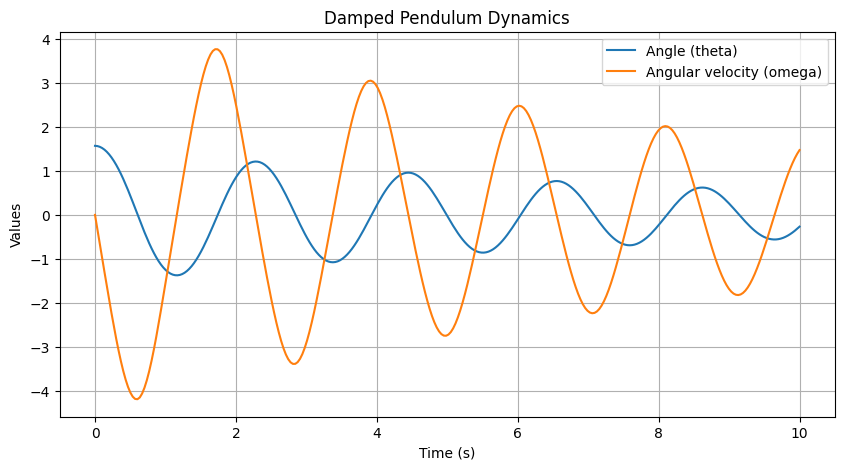

In [53]:
# Define the damped pendulum equation
def damped_pendulum(t, y, b, c):
    theta, omega = y
    dydt = [omega, -b * omega - c * np.sin(theta)]
    return dydt

# Parameters
b = 0.2  # Damping coefficient
c = 9.81  # Gravity constant (assuming unit length)
y0 = [np.pi / 2, 0]  # Initial condition: [initial angle, initial angular velocity]
t_span = (0, 10)  # Time range
t_eval = np.linspace(*t_span, 300)  # Time points for evaluation

# Solve the differential equation
sol = solve_ivp(damped_pendulum, t_span, y0, t_eval=t_eval, args=(b, c))

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(sol.t, sol.y[0], label='Angle (theta)')
plt.plot(sol.t, sol.y[1], label='Angular velocity (omega)')
plt.xlabel('Time (s)')
plt.ylabel('Values')
plt.title('Damped Pendulum Dynamics')
plt.legend()
plt.grid()
plt.show()

## PINN

Epoch 0, Loss: 8.3878173828125
Epoch 500, Loss: 0.23723840713500977
Epoch 1000, Loss: 0.22183437645435333
Epoch 1500, Loss: 0.21391871571540833
Epoch 2000, Loss: 0.20742209255695343
Epoch 2500, Loss: 0.2033931314945221
Epoch 3000, Loss: 0.19725190103054047
Epoch 3500, Loss: 0.1874445676803589
Epoch 4000, Loss: 0.17943978309631348
Epoch 4500, Loss: 0.25620248913764954
Epoch 5000, Loss: 0.1736735999584198
Epoch 5500, Loss: 0.16383159160614014
Epoch 6000, Loss: 0.15958596765995026
Epoch 6500, Loss: 0.14603085815906525
Epoch 7000, Loss: 0.13692745566368103
Epoch 7500, Loss: 0.1313077062368393
Epoch 8000, Loss: 0.12552839517593384
Epoch 8500, Loss: 0.11797385662794113
Epoch 9000, Loss: 0.11426153033971786
Epoch 9500, Loss: 0.11729589849710464
Epoch 10000, Loss: 0.11478247493505478
Epoch 10500, Loss: 0.11277789622545242
Epoch 11000, Loss: 0.1102323904633522
Epoch 11500, Loss: 0.10344506800174713
Epoch 12000, Loss: 0.09068042784929276
Epoch 12500, Loss: 0.074971042573452
Epoch 13000, Loss: 0.

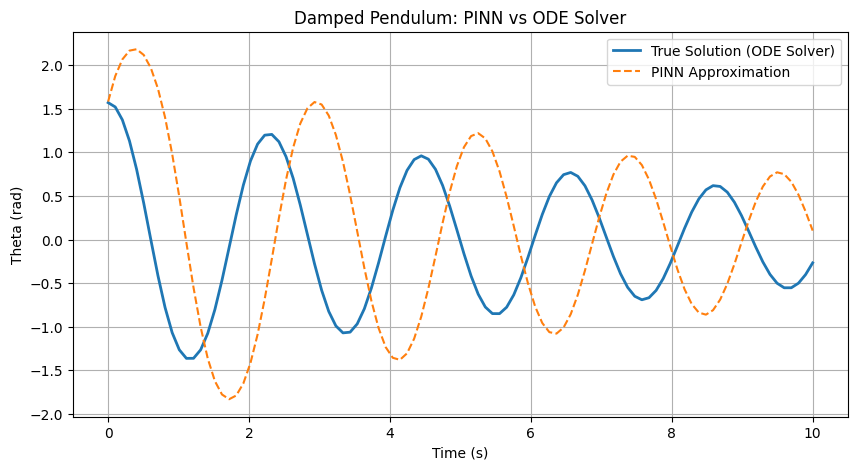

In [66]:
# Solve the system using a numerical ODE solver for comparison
t_span = (0, 10)
nr_samples = 100
y0 = [np.pi / 2, 0]  # Initial conditions


t_train = torch.linspace(*t_span, nr_samples).reshape(-1, 1)  # Training time points
sol = solve_ivp(damped_pendulum, t_span, y0, t_eval=t_train.numpy().flatten(), args=(b, c))
theta_true = torch.tensor(sol.y[0], dtype=torch.float32).reshape(-1, 1)

lambda1, lambda2 = 1e-1, 1e-4  # Regularization parameters

# Define the PINN model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, t):
        return self.net(t)

# Initialize the model and optimizer
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 50000
for epoch in range(epochs):
    optimizer.zero_grad()

    t = t_train.clone().requires_grad_(True)
    theta_pred = model(t)

    # Initial condition loss
    u_boundary = theta_pred[0]  # Evaluate network at t = 0
    loss1 = (torch.squeeze(u_boundary) - np.pi / 2) ** 2  # Enforce theta(0) = pi/2

    # Compute derivative u'(0) via autograd
    dudt_boundary = torch.autograd.grad(
        outputs=u_boundary,
        inputs=t,
        grad_outputs=torch.ones_like(u_boundary),
        create_graph=True
    )[0][0]  # Ensure we get a scalar

    loss2 = (torch.squeeze(dudt_boundary) - 0) ** 2  # Enforce theta'(0) = 0

    # Compute derivatives using autograd
    theta_t = torch.autograd.grad(theta_pred, t, torch.ones_like(theta_pred), create_graph=True)[0]
    theta_tt = torch.autograd.grad(theta_t, t, torch.ones_like(theta_t), create_graph=True)[0]

    # Compute the physics-informed loss (forcing the neural network to satisfy the ODE)
    residual = theta_tt + b * theta_t + c * torch.sin(theta_pred)
    loss_pde = torch.mean(residual ** 2)

    # Total loss
    loss = loss_pde + lambda1 * loss1 + lambda2 * loss2

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Generate predictions
theta_pinn = model(t_train).detach().numpy()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(t_train.numpy(), theta_true.numpy(), label="True Solution (ODE Solver)", linewidth=2)
plt.plot(t_train.numpy(), theta_pinn, label="PINN Approximation", linestyle="dashed")
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.title("Damped Pendulum: PINN vs ODE Solver")
plt.legend()
plt.grid()
plt.show()

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.integrate import solve_ivp

# Define time span
t_span = (0, 10)
nr_samples = 100
t_train = torch.linspace(*t_span, nr_samples).reshape(-1, 1)
t_train = t_train.requires_grad_(True)  # Ensure gradients can be computed

# Define the true parameters
# Parameters
b = 0.2  # True damping coefficient
c = 9.81  # Gravity constant (assuming unit length)

# Solve the system using a numerical ODE solver for comparison
def damped_pendulum(t, y, b, c):
    theta, omega = y
    return [omega, -b * omega - c * np.sin(theta)]

y0 = [np.pi / 2, 0]  # Initial conditions
sol = solve_ivp(damped_pendulum, t_span, y0, t_eval=t_train.detach().numpy().flatten(), args=(b, c))

# Add noise to simulate measurement errors
noise_std = 0.05  # Noise standard deviation
theta_noisy = sol.y[0] + noise_std * np.random.randn(*sol.y[0].shape)
theta_noisy = torch.tensor(theta_noisy, dtype=torch.float32).reshape(-1, 1)

# Define the improved PINN model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.SiLU(),
            nn.Linear(64, 64),
            nn.SiLU(),
            nn.Linear(64, 64),
            nn.SiLU(),
            nn.Linear(64, 1)
        )

    def forward(self, t):
        return self.net(t)

# Initialize model and optimizer
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5000, verbose=True)

lambda1, lambda2, lambda3 = 1e-1, 1e-4, 1e-0  # Regularization parameters
batch_size = 64
num_batches = len(t_train) // batch_size

# Pre-train on noisy data
for epoch in range(5000):
    optimizer.zero_grad()
    theta_pred = model(t_train)
    loss_data = torch.mean((theta_pred - theta_noisy) ** 2)
    loss_data.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(f"Pre-train Epoch {epoch}, Loss: {loss_data.item()}")

# Main training loop
epochs = 50000
for epoch in range(epochs):
    optimizer.zero_grad()
    indices = torch.randperm(len(t_train))[:batch_size]
    t = t_train[indices].clone().requires_grad_(True)
    theta_pred = model(t)

    # Compute derivatives
    theta_t = torch.autograd.grad(theta_pred, t, torch.ones_like(theta_pred), create_graph=True)[0]
    theta_tt = torch.autograd.grad(theta_t, t, torch.ones_like(theta_t), create_graph=True)[0]

    # Physics-informed loss (b is fixed to b_true)
    residual = theta_tt + b * theta_t + c * torch.sin(theta_pred)
    loss_pde = torch.mean(residual ** 2)

    # Initial condition loss
    t0 = t_train[0].clone().detach().requires_grad_(True)
    loss1 = (model(t0) - np.pi / 2) ** 2
    loss2 = (torch.autograd.grad(model(t0), t0, torch.ones_like(model(t0)), create_graph=True)[0] - 0) ** 2

    # Data loss
    loss_data = torch.mean((model(t_train) - theta_noisy) ** 2)

    # Adaptive weight balancing
    total_loss = loss_pde + lambda1 * loss1 + lambda2 * loss2 + lambda3 * loss_data
    total_loss.backward()

    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step(total_loss)

    if epoch % 2500 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss.item()}")


Pre-train Epoch 0, Loss: 0.555449903011322
Pre-train Epoch 1000, Loss: 0.006498878821730614
Pre-train Epoch 2000, Loss: 0.001450978103093803
Pre-train Epoch 3000, Loss: 0.0013962478842586279
Pre-train Epoch 4000, Loss: 0.0012840009294450283
Epoch 0, Loss: 8.230701446533203
Epoch 2500, Loss: 0.2526845932006836
Epoch 5000, Loss: 0.1302972435951233
Epoch 7500, Loss: 0.10054060071706772
Epoch 10000, Loss: 0.08427602052688599
Epoch 12500, Loss: 0.07517115771770477
Epoch 15000, Loss: 0.07225789874792099
Epoch 17500, Loss: 0.07808157801628113
Epoch 20000, Loss: 0.08428935706615448
Epoch 22500, Loss: 0.07616809755563736
Epoch 25000, Loss: 0.07331778109073639
Epoch 27500, Loss: 0.0727558434009552
Epoch 30000, Loss: 0.07341455668210983
Epoch 32500, Loss: 0.0766119733452797
Epoch 35000, Loss: 0.07207123190164566
Epoch 37500, Loss: 0.07275311648845673
Epoch 40000, Loss: 0.07202102243900299
Epoch 42500, Loss: 0.07242385298013687
Epoch 45000, Loss: 0.07188604027032852
Epoch 47500, Loss: 0.0729793384

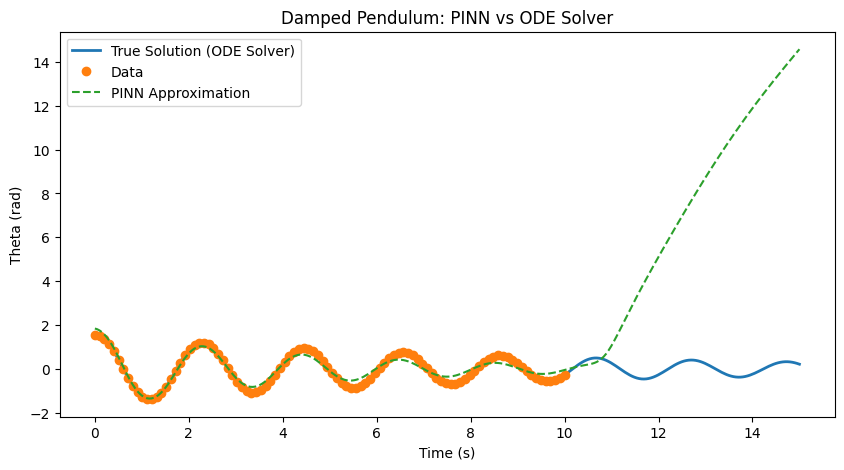

In [78]:
# Generate predictions
t_span = (0, 15)
nr_samples = 300 # better plot
t_train_long = torch.linspace(*t_span, nr_samples).reshape(-1, 1)  # Training time points
y0 = [np.pi / 2, 0]  # Initial conditions
sol = solve_ivp(damped_pendulum, t_span, y0, t_eval=t_train_long.numpy().flatten(), args=(b, c))
theta_true_long = torch.tensor(sol.y[0], dtype=torch.float32).reshape(-1, 1)
theta_pinn_long = model(t_train_long).detach().numpy()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(t_train_long.numpy(), theta_true_long.numpy(), label="True Solution (ODE Solver)", linewidth=2)
plt.plot(t_train.detach().numpy(), theta_true, label="Data", marker='o', linestyle='')
plt.plot(t_train_long.numpy(), theta_pinn_long, label="PINN Approximation", linestyle="dashed")
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.title("Damped Pendulum: PINN vs ODE Solver")
plt.legend()
# plt.grid()
plt.savefig("Figures/Damped_pendulum_PINN_and_HNNs.png")

plt.show()

## PINN with learnable damping

In [80]:
t_span = (0, 10)
t_train = torch.linspace(*t_span, 300).reshape(-1, 1)
t_train = t_train.requires_grad_(True)  # Ensure gradients can be computed

# Solve the system using a numerical ODE solver for comparison
def damped_pendulum(t, y, b, c):
    theta, omega = y
    return [omega, -b * omega - c * np.sin(theta)]

y0 = [np.pi / 2, 0]  # Initial conditions
sol = solve_ivp(damped_pendulum, t_span, y0, t_eval=t_train.detach().numpy().flatten(), args=(b, c))

# Add noise to simulate measurement errors
noise_std = 0.05  # Noise standard deviation
theta_noisy = sol.y[0] + noise_std * np.random.randn(*sol.y[0].shape)
theta_noisy = torch.tensor(theta_noisy, dtype=torch.float32).reshape(-1, 1)

# Define the improved PINN model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.SiLU(),
            nn.Linear(64, 64),
            nn.SiLU(),
            nn.Linear(64, 64),
            nn.SiLU(),
            nn.Linear(64, 1)
        )
        self.b = nn.Parameter(torch.tensor(0.5, dtype=torch.float32))  # Initialize with an arbitrary guess

    def forward(self, t):
        return self.net(t)

# Initialize model and optimizer
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5000, verbose=True)

lambda1, lambda2, lambda3 = 1e-1, 1e-4, 1e-0  # Regularization parameters
batch_size = 64
num_batches = len(t_train) // batch_size

# Pre-train on noisy data
for epoch in range(5000):
    optimizer.zero_grad()
    theta_pred = model(t_train)
    loss_data = torch.mean((theta_pred - theta_noisy) ** 2)
    loss_data.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(f"Pre-train Epoch {epoch}, Loss: {loss_data.item()}")

# Main training loop
epochs = 50000
for epoch in range(epochs):
    optimizer.zero_grad()
    indices = torch.randperm(len(t_train))[:batch_size]
    t = t_train[indices].clone().requires_grad_(True)
    theta_pred = model(t)

    # Compute derivatives
    theta_t = torch.autograd.grad(theta_pred, t, torch.ones_like(theta_pred), create_graph=True)[0]
    theta_tt = torch.autograd.grad(theta_t, t, torch.ones_like(theta_t), create_graph=True)[0]

    # Physics-informed loss
    residual = theta_tt + model.b * theta_t + c * torch.sin(theta_pred)
    loss_pde = torch.mean(residual ** 2)

    # Initial condition loss
    t0 = t_train[0].clone().detach().requires_grad_(True)
    loss1 = (model(t0) - np.pi / 2) ** 2
    loss2 = (torch.autograd.grad(model(t0), t0, torch.ones_like(model(t0)), create_graph=True)[0] - 0) ** 2

    # Data loss
    loss_data = torch.mean((model(t_train) - theta_noisy) ** 2)

    # Adaptive weight balancing
    total_loss = loss_pde + lambda1 * loss1 + lambda2 * loss2 + lambda3 * loss_data
    total_loss.backward()

    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step(total_loss)

    if epoch % 2500 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss.item()}, Learned b: {model.b.item()}")


Pre-train Epoch 0, Loss: 0.5652749538421631
Pre-train Epoch 1000, Loss: 0.0026661567389965057
Pre-train Epoch 2000, Loss: 0.0027039675042033195
Pre-train Epoch 3000, Loss: 0.0026199608109891415
Pre-train Epoch 4000, Loss: 0.003991914447396994
Epoch 0, Loss: 32.20903778076172, Learned b: 0.49500009417533875
Epoch 2500, Loss: 0.13445305824279785, Learned b: 0.4688519239425659
Epoch 5000, Loss: 0.12082487344741821, Learned b: 0.42383596301078796
Epoch 7500, Loss: 0.025243747979402542, Learned b: 0.24912624061107635
Epoch 10000, Loss: 0.0330098457634449, Learned b: 0.22176885604858398
Epoch 12500, Loss: 0.029143359512090683, Learned b: 0.21870797872543335
Epoch 15000, Loss: 0.02245977148413658, Learned b: 0.21378183364868164
Epoch 17500, Loss: 0.012498188763856888, Learned b: 0.21897660195827484
Epoch 20000, Loss: 0.008248088881373405, Learned b: 0.21524566411972046
Epoch 22500, Loss: 0.016040824353694916, Learned b: 0.211957648396492
Epoch 25000, Loss: 0.009388457052409649, Learned b: 0.2

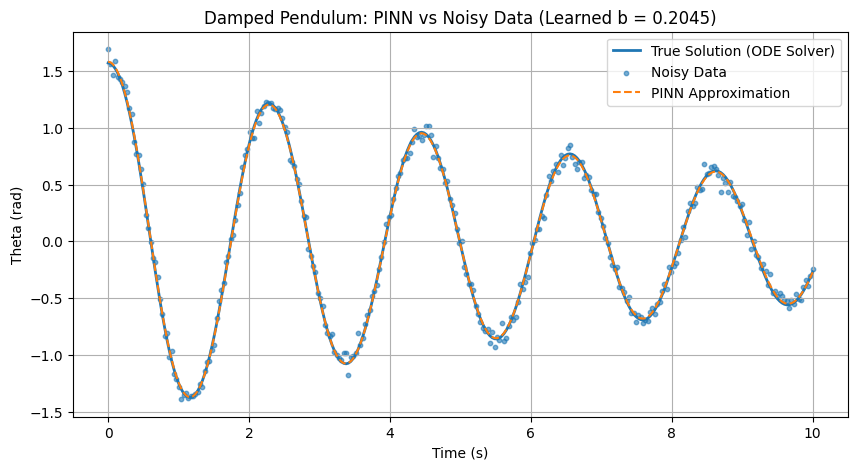

In [86]:
t_span = (0, 10)
t_train = torch.linspace(*t_span, 300).reshape(-1, 1)
t_train = t_train.requires_grad_(True)  # Ensure gradients can be computed
y0 = [np.pi / 2, 0]  # Initial conditions
sol = solve_ivp(damped_pendulum, t_span, y0, t_eval=t_train.detach().numpy().flatten(), args=(b, c))
# Generate predictions
theta_pinn = model(t_train).detach().numpy()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(t_train.detach().numpy(), sol.y[0], label="True Solution (ODE Solver)", linewidth=2, )
plt.scatter(t_train.detach().numpy(), theta_noisy.numpy(), label="Noisy Data", s=10, alpha=0.6)
plt.plot(t_train.detach().numpy(), theta_pinn, label="PINN Approximation", linestyle="dashed")
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.title(f"Damped Pendulum: PINN vs Noisy Data (Learned b = {model.b.item():.4f})")
plt.legend()
plt.grid()
plt.savefig("Figures/Damped_pendulum_PINN_vs_Noisy.png")
plt.show()

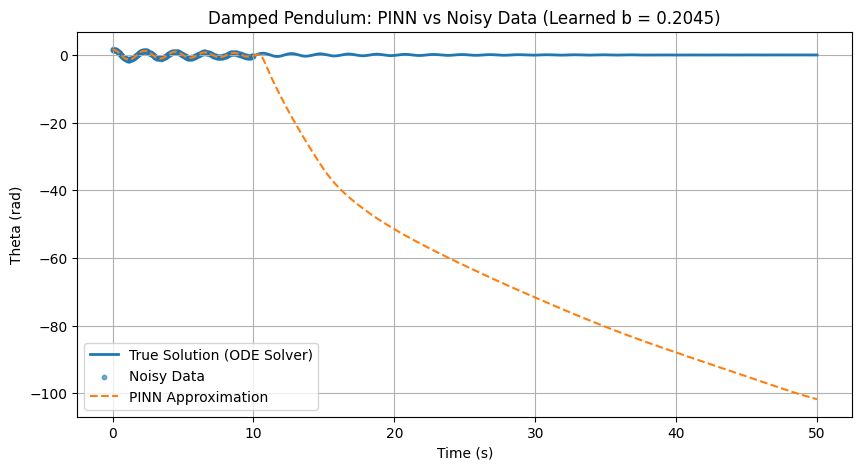

In [87]:
t_span = (0, 50)
t_test = torch.linspace(*t_span, 5000).reshape(-1, 1)  # Training time points

# Generate predictions
theta_pinn = model(t_test).detach().numpy()

y0 = [np.pi / 2, 0]  # Initial conditions
sol = solve_ivp(damped_pendulum, t_span, y0, t_eval=t_test.numpy().flatten(), args=(b, c))

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(t_test.numpy(), sol.y[0], label="True Solution (ODE Solver)", linewidth=2)
plt.scatter(t_train.detach().numpy(), theta_noisy.numpy(), label="Noisy Data", s=10, alpha=0.6)
plt.plot(t_test.numpy(), theta_pinn, label="PINN Approximation", linestyle="dashed")
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.title(f"Damped Pendulum: PINN vs Noisy Data (Learned b = {model.b.item():.4f})")
plt.legend()
plt.grid()
plt.savefig("Figures/Damped_pendulum_PINN_vs_Noisy_long.png")
plt.show()

## Standard NN for comparison

In [18]:
# Define constants
t_span = (0, 10)
t_train = torch.linspace(*t_span, 300).reshape(-1, 1)  # Training time points

# Solve the system using a numerical ODE solver for ground truth
def damped_pendulum(t, y, b, c):
    theta, omega = y
    return [omega, -b * omega - c * np.sin(theta)]

y0 = [np.pi / 2, 0]  # Initial conditions
sol = solve_ivp(damped_pendulum, t_span, y0, t_eval=t_train.numpy().flatten(), args=(b, c))

# Add noise to simulate measurement errors
noise_std = 0.05  # Noise standard deviation
theta_noisy = sol.y[0] + noise_std * np.random.randn(*sol.y[0].shape)
theta_noisy = torch.tensor(theta_noisy, dtype=torch.float32).reshape(-1, 1)

# Define a standard neural network model (purely data-driven)
class StandardNN(nn.Module):
    def __init__(self):
        super(StandardNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, t):
        return self.net(t)

# Initialize the model and optimizer
model = StandardNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # Mean Squared Error Loss

# Training loop
epochs = 100000
for epoch in range(epochs):
    optimizer.zero_grad()

    theta_pred = model(t_train)
    loss = criterion(theta_pred, theta_noisy)  # Minimize error w.r.t. noisy observations

    loss.backward()
    optimizer.step()

    if epoch % 2500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 0.625273585319519
Epoch 2500, Loss: 0.05207584798336029
Epoch 5000, Loss: 0.0023912619799375534
Epoch 7500, Loss: 0.002213678089901805
Epoch 10000, Loss: 0.0021201062481850386
Epoch 12500, Loss: 0.002105574356392026
Epoch 15000, Loss: 0.0021012688521295786
Epoch 17500, Loss: 0.002096909563988447
Epoch 20000, Loss: 0.002116454765200615
Epoch 22500, Loss: 0.002089473884552717
Epoch 25000, Loss: 0.0020930760074406862
Epoch 27500, Loss: 0.002082854276522994
Epoch 30000, Loss: 0.0020804922096431255
Epoch 32500, Loss: 0.0020785804372280836
Epoch 35000, Loss: 0.002076860750094056
Epoch 37500, Loss: 0.0020746830850839615
Epoch 40000, Loss: 0.0021710162982344627
Epoch 42500, Loss: 0.0020699878223240376
Epoch 45000, Loss: 0.0020737953018397093
Epoch 47500, Loss: 0.0020636101253330708
Epoch 50000, Loss: 0.0020785031374543905
Epoch 52500, Loss: 0.0020901516545563936
Epoch 55000, Loss: 0.002056313445791602
Epoch 57500, Loss: 0.0020682935137301683
Epoch 60000, Loss: 0.0020474283955991

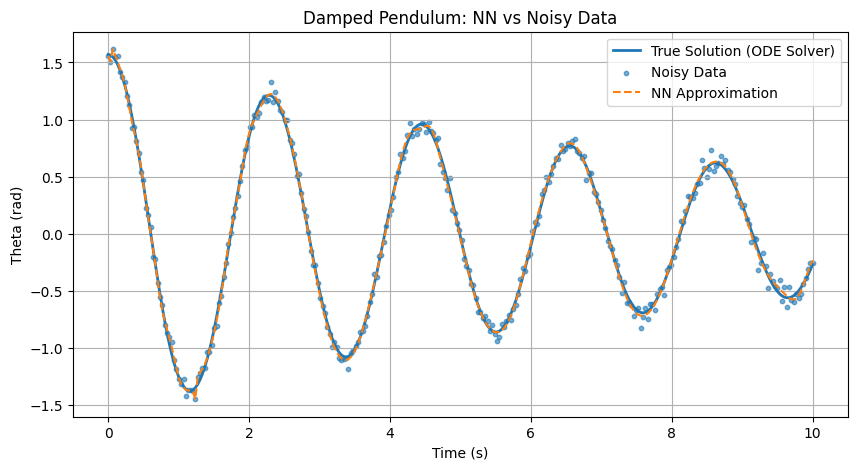

In [19]:
# Generate predictions
theta_nn = model(t_train).detach().numpy()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(t_train.numpy(), sol.y[0], label="True Solution (ODE Solver)", linewidth=2, )
plt.scatter(t_train.numpy(), theta_noisy.numpy(), label="Noisy Data", s=10, alpha=0.6)
plt.plot(t_train.numpy(), theta_nn, label="NN Approximation", linestyle="dashed")
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.title(f"Damped Pendulum: NN vs Noisy Data")
plt.legend()
plt.grid()
plt.show()

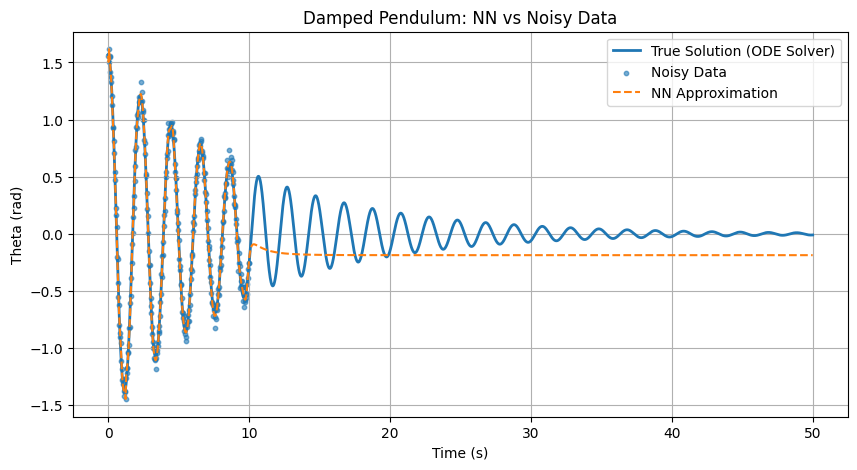

In [20]:
# Generate predictions

t_span = (0, 50)
t_test = torch.linspace(*t_span, 5000).reshape(-1, 1)  # Training time points


theta_nn = model(t_test).detach().numpy()

y0 = [np.pi / 2, 0]  # Initial conditions
sol = solve_ivp(damped_pendulum, t_span, y0, t_eval=t_test.numpy().flatten(), args=(b, c))



# Plot results
plt.figure(figsize=(10, 5))
plt.plot(t_test.numpy(), sol.y[0], label="True Solution (ODE Solver)", linewidth=2, )
plt.scatter(t_train.numpy(), theta_noisy.numpy(), label="Noisy Data", s=10, alpha=0.6)
plt.plot(t_test.numpy(), theta_nn, label="NN Approximation", linestyle="dashed")
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.title(f"Damped Pendulum: NN vs Noisy Data")
plt.legend()
plt.grid()
plt.show()

## Hamiltonian Neural Networks

In [21]:
class HamiltonianTrue:
    def __init__(self,k=2.4, gamma=0.5):
        self.k = k
        self.gamma = gamma

    def hamiltonian_fn(self, coords):
        """
        Hamiltonian function for a damped pendulum.
        """
        q, p = torch.chunk(coords, 2, dim=-1)  # Ensure proper splitting
        H = self.k * (1 - torch.cos(q)) + p**2  # Standard pendulum Hamiltonian
        D = self.gamma * p**2  # Quadratic damping
        return H - D  # Energy loss due to dissipation

    def time_derivative(self, t, state):
        """
        Compute dq/dt and dp/dt using the Hamiltonian function and autograd.
        """
        state = torch.tensor(state, dtype=torch.float32, requires_grad=True).view(1, -1)  # Ensure shape
        H = self.hamiltonian_fn(state)  # Compute the Hamiltonian
        dH = torch.autograd.grad(H.sum(), state, create_graph=True)[0]  # Compute gradients

        dq_dt = dH[0, 1]  # ∂H/∂p
        dp_dt = -dH[0, 0] - self.gamma * dH[0, 1]  # -∂H/∂q - damping term
        return [dq_dt.item(), dp_dt.item()]

    def integrate(self, t_span=[0, 10], y0=[np.pi / 2, 0], resolution=1000):
        sol = solve_ivp(lambda t, y: self.time_derivative(t, y), t_span, y0, t_eval=np.linspace(*t_span, resolution))
        return sol.t, sol.y[0], sol.y[1]

    def get_field(self, xmin=-np.pi/2, xmax=np.pi/2, ymin=-np.pi/2, ymax=np.pi/2, gridsize=20):
        """
        Computes the vector field (q, p, dq/dt, dp/dt) for the dynamical system.

        Args:
            xmin, xmax: Range for q (angle).
            ymin, ymax: Range for p (momentum).
            gridsize: Number of points in each dimension.

        Returns:
            ys.T: Grid points.
            dydt.T: Corresponding velocity vectors (dq/dt, dp/dt).
        """
        # Create a grid in phase space
        b, a = np.meshgrid(np.linspace(xmin, xmax, gridsize), np.linspace(ymin, ymax, gridsize))
        ys = np.stack([b.flatten(), a.flatten()], axis=1)  # Shape (N, 2)

        # Compute the vector field at each grid point
        dydt = np.array([self.time_derivative(None, y) for y in ys])  # Shape (N, 2)

        return ys, dydt


In [88]:
# Initialize system
k=c
gamma=b
hamiltonian_true = HamiltonianTrue(k=k, gamma=gamma)

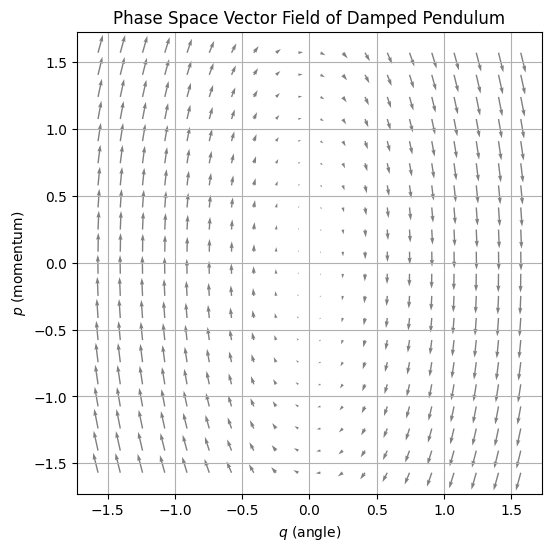

In [89]:
# Get the vector field
field, directions = hamiltonian_true.get_field(gridsize=20)

# Plot configuration
fig, ax = plt.subplots(figsize=(6, 6))
ax.quiver(field[:, 0], field[:, 1], directions[:, 0], directions[:, 1], color="gray", angles='xy')

plt.xlabel("$q$ (angle)")
plt.ylabel("$p$ (momentum)")
plt.title("Phase Space Vector Field of Damped Pendulum")
plt.grid()
plt.show()

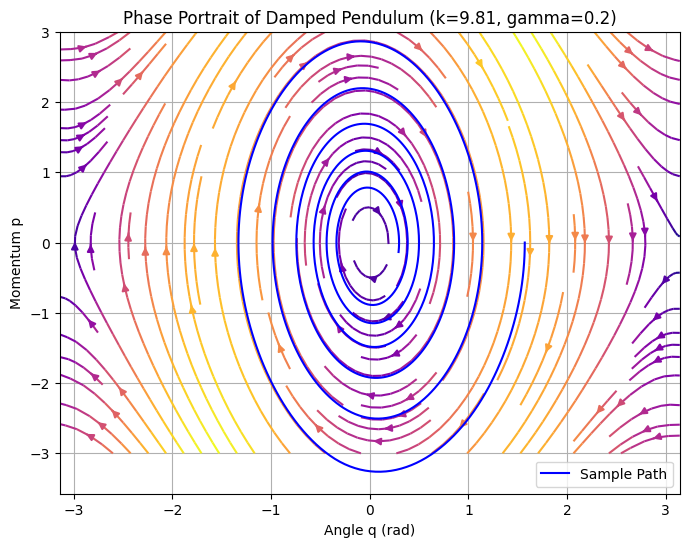

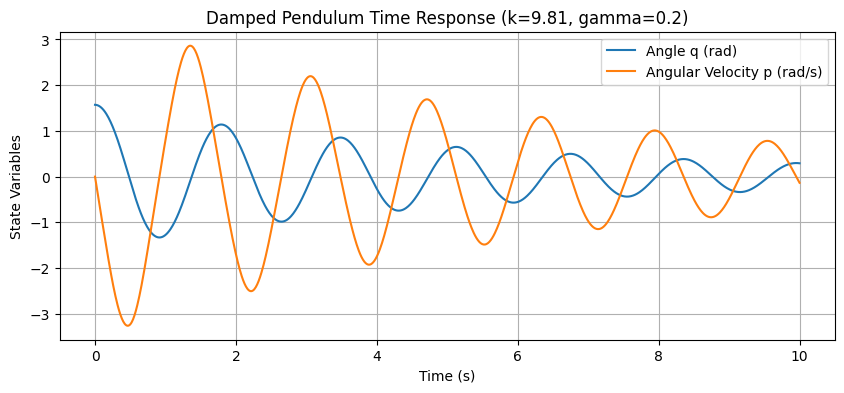

In [90]:
def plot_phase_portrait(k=hamiltonian_true.k, gamma=hamiltonian_true.gamma, q_range=(-np.pi, np.pi), p_range=(-3, 3), grid_size=20):
    """
    Plots the phase portrait of the damped pendulum with a sample trajectory.
    """
    q_vals = np.linspace(q_range[0], q_range[1], grid_size)
    p_vals = np.linspace(p_range[0], p_range[1], grid_size)
    Q, P = np.meshgrid(q_vals, p_vals)

    dQ, dP = np.zeros(Q.shape), np.zeros(P.shape)
    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            dQ[i, j], dP[i, j] = hamiltonian_true.time_derivative(0, [Q[i, j], P[i, j]])

    plt.figure(figsize=(8, 6))
    plt.streamplot(Q, P, dQ, dP, color=np.sqrt(dQ**2 + dP**2), cmap='plasma', density=1.2)

    # Solve and plot a single trajectory
    t_span = [0, 10]
    y0 = [np.pi / 2, 0]  # Initial condition: (q0, p0)
    sol = hamiltonian_true.integrate(t_span, y0)
    plt.plot(sol[1], sol[2], 'b', label="Sample Path")

    plt.xlabel("Angle q (rad)")
    plt.ylabel("Momentum p")
    plt.title(f"Phase Portrait of Damped Pendulum (k={k}, gamma={gamma})")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Time Response
    plt.figure(figsize=(10, 4))
    plt.plot(sol[0], sol[1], label="Angle q (rad)")
    plt.plot(sol[0], sol[2], label="Angular Velocity p (rad/s)")
    plt.xlabel("Time (s)")
    plt.ylabel("State Variables")
    plt.title(f"Damped Pendulum Time Response (k={k}, gamma={gamma})")
    plt.legend()
    plt.grid()
    plt.show()



# Run the phase plot function
plot_phase_portrait()

In [91]:
def generate_noisy_data(samples=100, noise_std=0.05, t_span = [0, 10], y0 = [np.pi / 2, 0]):
    """
    Generates synthetic data from HamiltonianTrue and adds Gaussian noise.

    Args:
        samples: Number of samples to generate.
        noise_std: Standard deviation of the noise.

    Returns:
        Torch tensors for training: (q, p, dq/dt, dp/dt)
    """
    t_eval = np.linspace(*t_span, samples)

    # Integrate the true system
    sol = hamiltonian_true.integrate(t_span, y0, resolution=samples)
    q, p = sol[1], sol[2]

    dq_dt, dp_dt = np.array([hamiltonian_true.time_derivative(0, [q_i, p_i]) for q_i, p_i in zip(q, p)]).T

    # # Compute derivatives
    # dq_dt, dp_dt = np.gradient(q, t_eval), np.gradient(p, t_eval)

    # Add Gaussian noise
    q += np.random.normal(0, noise_std, q.shape)
    p += np.random.normal(0, noise_std, p.shape)
    dq_dt += np.random.normal(0, noise_std, dq_dt.shape)
    dp_dt += np.random.normal(0, noise_std, dp_dt.shape)

    # Convert to Torch tensors
    q, p, dq_dt, dp_dt = map(lambda x: torch.tensor(x, dtype=torch.float32), [q, p, dq_dt, dp_dt])

    return q, p, dq_dt, dp_dt, t_eval

# Prepare dataset

In [92]:
import torch.nn as nn
# Define Multi-Layer Perceptron (MLP)
# Corrected MLP class
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        """
        Multi-Layer Perceptron for the HNN.

        Args:
            input_dim: Number of input features.
            output_dim: Number of output features.
            hidden_dim: Number of hidden neurons.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x, t=None):
        inputs = torch.cat([x, t], axis=-1) if t is not None else x
        return self.net(inputs)


    def integrate(self, t_span=[0, 10], y0=[np.pi / 2, 0], resolution=1000):
        """
        Integrates the learned system dynamics over time using solve_ivp.

        Args:
            t_span: Time range for integration.
            y0: Initial conditions [q0, p0].
            resolution: Number of time steps.

        Returns:
            t, q, p: Time steps and corresponding trajectories.
        """
        sol = solve_ivp(
            lambda t, y: self.forward(torch.tensor(y, dtype=torch.float32, requires_grad=True).view(1, -1)).detach().numpy().flatten(),
            t_span, y0, t_eval=np.linspace(*t_span, resolution)
        )
        return sol.t, sol.y[0], sol.y[1]

# Define Hamiltonian Neural Network (HNN)
class HNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.mlp = MLP(input_dim, 1, hidden_dim)

    def forward(self, x, t=None):
        inputs = torch.cat([x, t], axis=-1) if t is not None else x
        H = self.mlp(inputs)[..., 0]
        H_grads = torch.autograd.grad(H.sum(), x, create_graph=True)[0]
        dHdq, dHdp = torch.split(H_grads, H_grads.shape[-1] // 2, dim=1)
        return torch.cat([dHdp, -dHdq], axis=-1)

    def predict_hamiltonian(self, x, t=None):
        return self.mlp(x, t)

    def integrate(self, t_span=[0, 10], y0=[np.pi / 2, 0], resolution=1000):
        """
        Integrates the learned system dynamics over time using solve_ivp.

        Args:
            t_span: Time range for integration.
            y0: Initial conditions [q0, p0].
            resolution: Number of time steps.

        Returns:
            t, q, p: Time steps and corresponding trajectories.
        """
        sol = solve_ivp(
            lambda t, y: self.forward(torch.tensor(y, dtype=torch.float32, requires_grad=True).view(1, -1)).detach().numpy().flatten(),
            t_span, y0, t_eval=np.linspace(*t_span, resolution)
        )
        return sol.t, sol.y[0], sol.y[1]

    def save_model(self, model_path="hnn_weights.pth"):
        """Save the model's state_dict to a file."""
        torch.save(self.state_dict(), model_path)
        print(f"Model weights saved to {model_path}")

    def load_model(self, model_path="hnn_weights.pth"):
        """Load the model's state_dict from a file."""
        self.load_state_dict(torch.load(model_path))
        self.eval()  # Set the model to evaluation mode
        print(f"Model weights loaded from {model_path}")


class DHNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.mlp_h = MLP(input_dim, 1, hidden_dim)  # Conservative component
        self.mlp_d = MLP(input_dim, 1, hidden_dim)  # Dissipative component

    def forward(self, x, t=None, as_separate=False):
        inputs = torch.cat([x, t], axis=-1) if t is not None else x
        D = self.mlp_d(inputs)
        H = self.mlp_h(inputs)

        # Compute gradients
        irr_component = torch.autograd.grad(D.sum(), x, create_graph=True, retain_graph=True)[0]
        rot_component = torch.autograd.grad(H.sum(), x, create_graph=True, retain_graph=True)[0]

        # Compute time derivatives
        dHdq, dHdp = torch.split(rot_component, rot_component.shape[-1] // 2, dim=1)
        q_dot_hat, p_dot_hat = dHdp, -dHdq
        rot_component = torch.cat([q_dot_hat, p_dot_hat], axis=-1)

        if as_separate:
            return irr_component, rot_component

        return irr_component + rot_component

    def predict_hamiltonian(self, x, t=None):
        x = x.view(-1, 2)  # Ensure correct shape
        predicted_H = self.mlp_h(x)
        predicted_D = self.mlp_d(x)
        total_H = predicted_H - predicted_D
        return total_H

    def integrate(self, t_span=[0, 10], y0=[np.pi / 2, 0], resolution=1000):
        """
        Integrates the learned system dynamics over time using solve_ivp.

        Args:
            t_span: Time range for integration.
            y0: Initial conditions [q0, p0].
            resolution: Number of time steps.

        Returns:
            t, q, p: Time steps and corresponding trajectories.
        """
        sol = solve_ivp(
            lambda t, y: self.forward(torch.tensor(y, dtype=torch.float32, requires_grad=True).view(1, -1)).detach().numpy().flatten(),
            t_span, y0, t_eval=np.linspace(*t_span, resolution)
        )
        return sol.t, sol.y[0], sol.y[1]

    def save_model(self, model_path="dhnn_weights.pth"):
        torch.save(self.state_dict(), model_path)
        print(f"Model weights saved to {model_path}")

    def load_model(self, model_path="dhnn_weights.pth"):
        self.load_state_dict(torch.load(model_path))
        self.eval()
        print(f"Model weights loaded from {model_path}")

In [124]:
# Define Loss Function and Optimizer
def train_hnn(model, train_loader, epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1000, factor=0.5)
    loss_fn = nn.MSELoss()
    loss_history = []
    increments_per_epoch = 100

    with tqdm(total=epochs) as pbar:
        total_loss = 0
        for epoch in range(epochs):
            for batch in train_loader:
                (x_batch, y_batch) = batch  # (q, p), (dq/dt, dp/dt)

                x_batch.requires_grad = True  # Needed for autograd
                y_pred = model(x_batch)  # Predict dynamics

                loss = loss_fn(y_pred, y_batch)  # Compute loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step(loss)
                total_loss += loss.item()

            if epoch % increments_per_epoch == 0:
                loss_history.append(loss.item())
                # Update pbar description with current loss and the last learning rate
                pbar.set_description(f'Epoch {epoch}, Loss: {loss.item():.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
            pbar.update()

        # Plotting the loss history
    plt.figure(figsize=(10, 5))
    plt.semilogy(np.arange(0, epochs, increments_per_epoch), loss_history, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("Training complete!")

def evaluate_hnn(model, model_name='HNN', k=hamiltonian_true.k, gamma=hamiltonian_true.gamma):
    """
    Evaluates the HNN model and plots predictions vs true dynamics.
    """
    # Integrate model and true system
    t_span=[0, 50]
    y0=[np.pi / 2, 0]
    resolution=1000
    t_pred, q_pred, p_pred = model.integrate(t_span=t_span, y0=y0, resolution=resolution)
    t_true, q_true, p_true = hamiltonian_true.integrate(t_span=t_span, y0=y0, resolution=resolution)

    # Create a subplot grid (2 rows, 2 columns) for better organization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Plot q(t) - True vs Predicted
    axes[0, 0].plot(t_true, q_true, label="True q", linestyle='-', color='blue', linewidth=2)
    axes[0, 0].plot(t_pred, q_pred, label="Predicted q", linestyle='--', color='red', linewidth=2)
    axes[0, 0].scatter(t_noisy, q_noisy, label="Data", c=t_noisy, s=14, cmap="viridis", alpha=0.9)
    axes[0, 0].set_xlabel("Time Steps")
    axes[0, 0].set_ylabel("q")
    axes[0, 0].legend()
    axes[0, 0].set_title(f"{model_name} Predictions vs True: q(t)")
    axes[0, 0].grid(True)

    # Plot p(t) - True vs Predicted
    axes[0, 1].plot(t_true, p_true, label="True p", linestyle='-', color='blue', linewidth=2)
    axes[0, 1].plot(t_pred, p_pred, label="Predicted p", linestyle='--', color='red', linewidth=2)
    axes[0, 1].scatter(t_noisy, p_noisy, label="Data", c=t_noisy, s=14, cmap="plasma", alpha=0.9)
    axes[0, 1].set_xlabel("Time Steps")
    axes[0, 1].set_ylabel("p")
    axes[0, 1].legend()
    axes[0, 1].set_title(f"{model_name} Predictions vs True: p(t)")
    axes[0, 1].grid(True)

    # Plot phase space (q, p) - True vs Predicted
    axes[1, 0].plot(q_true, p_true, label="True", linestyle='-', color='blue', linewidth=2)
    axes[1, 0].plot(q_pred, p_pred, label="Predicted", linestyle='--', color='red', linewidth=2)
    scatter = axes[1, 0].scatter(q_noisy, p_noisy, c=t_noisy, s=14, cmap="coolwarm", alpha=0.9, label='Data')
    axes[1, 0].set_xlabel("q")
    axes[1, 0].set_ylabel("p")
    axes[1, 0].legend()
    axes[1, 0].set_title(f"{model_name} Phase Space: Predictions vs True")
    axes[1, 0].grid(True)
    fig.colorbar(scatter, ax=axes[1, 0], label="Time")
    try:
        # Compute and plot Hamiltonian evolution
        coords_true = torch.stack([torch.tensor(q_true, dtype=torch.float32),
                                   torch.tensor(p_true, dtype=torch.float32)], dim=1)
        true_H = hamiltonian_true.hamiltonian_fn(coords_true).detach().numpy()

        coords_pred = torch.stack([torch.tensor(q_pred, dtype=torch.float32),
                                   torch.tensor(p_pred, dtype=torch.float32)], dim=1)
        predicted_H = model.predict_hamiltonian(coords_pred).detach().numpy()

        axes[1, 1].plot(true_H, label="True Hamiltonian", color='purple', linewidth=2)
        axes[1, 1].plot(predicted_H, label="Predicted Hamiltonian", linestyle="dashed", color='orange', linewidth=2)
        axes[1, 1].set_xlabel("Time Steps")
        axes[1, 1].set_ylabel("Hamiltonian Value")
        axes[1, 1].set_title("Hamiltonian Evolution Over Time")
        axes[1, 1].legend()
        axes[1, 1].grid(True)
    except:
        print("Hamiltonian prediction failed")

    plt.suptitle(f"{model_name} Results (k={k} and gamma={gamma})")
    plt.tight_layout()
    plt.savefig(f"figures/{model_name}.png")

    plt.show()

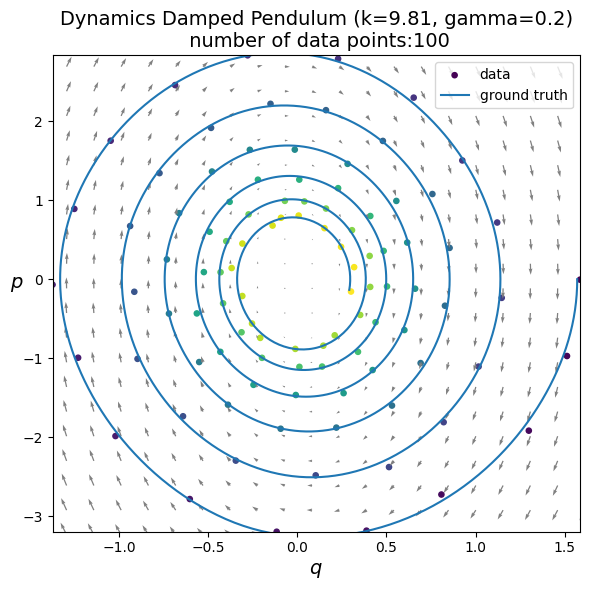

In [122]:
# Generate dataset
nr_data_points = 100
t_span=[0, 10]
q_noisy, p_noisy, dq_dt_noisy, dp_dt_noisy, t_noisy = generate_noisy_data(samples=nr_data_points, noise_std=0.025,t_span=t_span, y0=[np.pi / 2, 0])
q_true, p_true, dq_dt_true, dp_dt_true, t_true = generate_noisy_data(noise_std=0.0, samples=1000)

dataset = TensorDataset(torch.stack([q_noisy, p_noisy], dim=1), torch.stack([dq_dt_noisy, dp_dt_noisy], dim=1))
train_loader = DataLoader(dataset, batch_size=min(32, len(q_noisy) // 4), shuffle=True)

# Determine field limits dynamically
dataxmin, dataxmax = q_noisy.min().item(), q_noisy.max().item()
dataymin, dataymax = p_noisy.min().item(), p_noisy.max().item()

field = hamiltonian_true.get_field(gridsize=30,
                                   xmin=1.5*dataxmin, xmax=1.5*dataxmax, ymin=1.5*dataymin, ymax=1.5*dataymax)

# plot config
fig = plt.figure(figsize=(6, 6), facecolor='white')

plt.scatter(q_noisy, p_noisy, c=t_noisy, s=14, label='data')
plt.plot(q_true, p_true, label='ground truth')
plt.quiver(field[0][:,0], field[0][:,1], field[1][:,0], field[1][:,1],
           cmap='gray_r', color=(.5,.5,.5))
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title(f"Dynamics Damped Pendulum (k={hamiltonian_true.k}, gamma={hamiltonian_true.gamma})\n number of data points:{len(t_noisy)}", fontsize=14)
plt.legend(loc='upper right')

plt.xlim(dataxmin, dataxmax)
plt.ylim(dataymin, dataymax)
# plt.axis('equal')
plt.tight_layout()
plt.savefig("Figures/Damped_pendulum_dhnn_data.png")
plt.show()

In [119]:
# Initialize and train the HNN
input_dim = 2
hidden_dim = 64


Epoch 4900, Loss: 0.0232, LR: 0.000001: 100%|██████████| 5000/5000 [00:07<00:00, 675.13it/s]


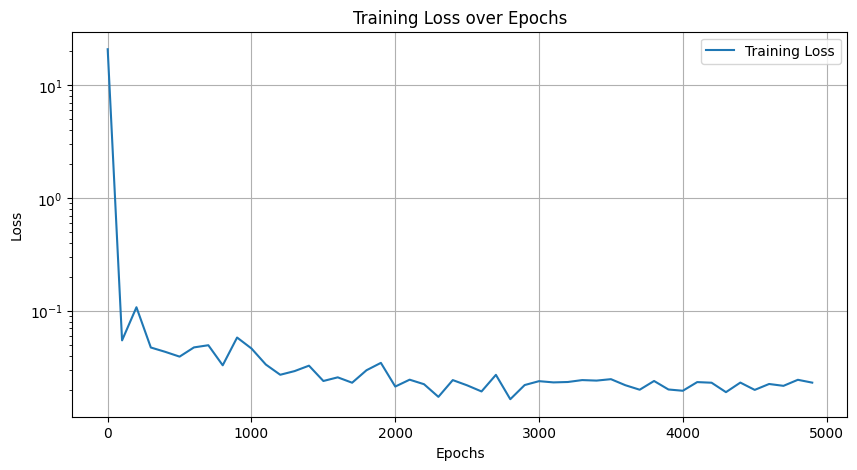

Training complete!


In [112]:
hnn_model = HNN(input_dim, hidden_dim)
train_hnn(hnn_model, train_loader, epochs=5000)

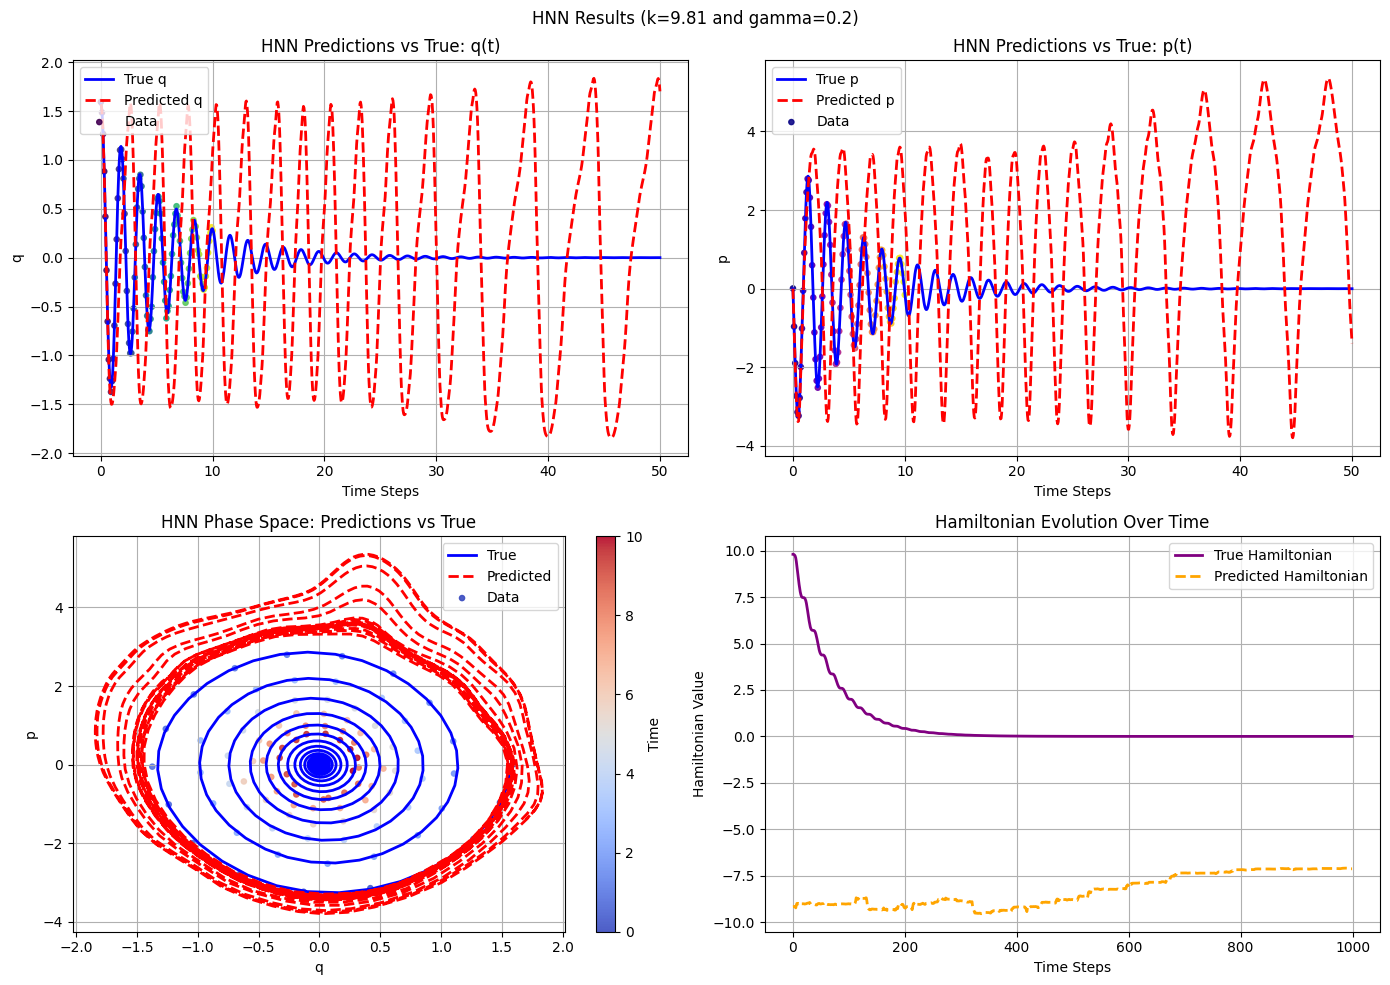

In [120]:
evaluate_hnn(hnn_model)

In [ ]:
dhnn_model = DHNN(input_dim, hidden_dim)
train_hnn(dhnn_model, train_loader, epochs=10000)

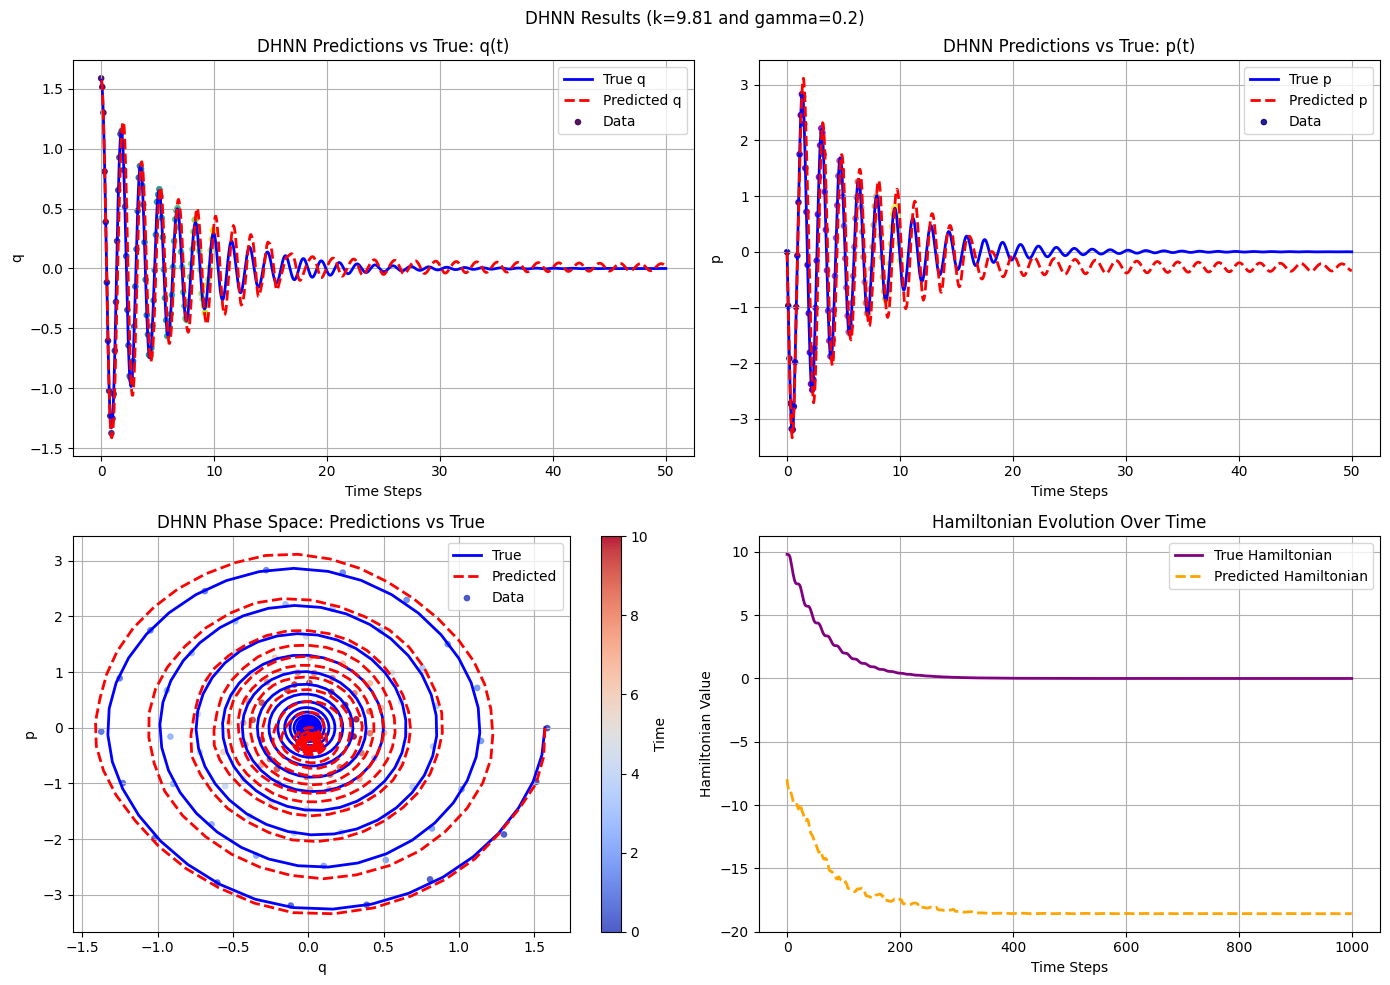

In [125]:
evaluate_hnn(dhnn_model, model_name='DHNN')

Epoch 4900, Loss: 0.0001, LR: 0.000010: 100%|██████████| 5000/5000 [00:06<00:00, 824.48it/s]


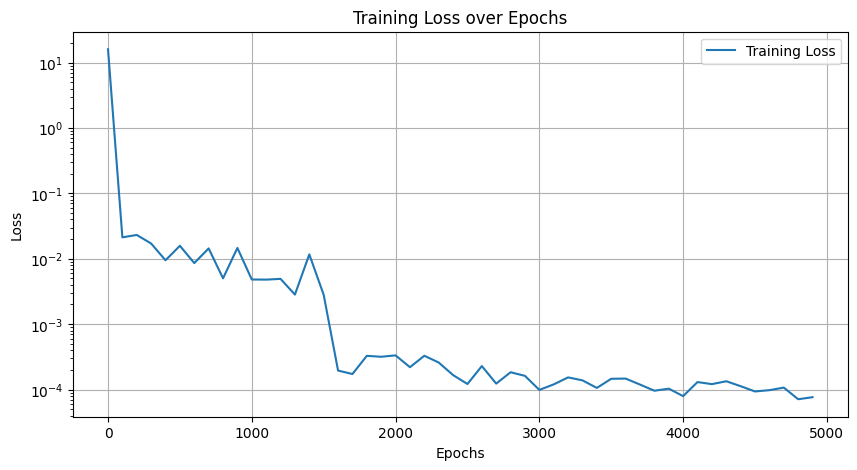

Training complete!
Hamiltonian prediction failed


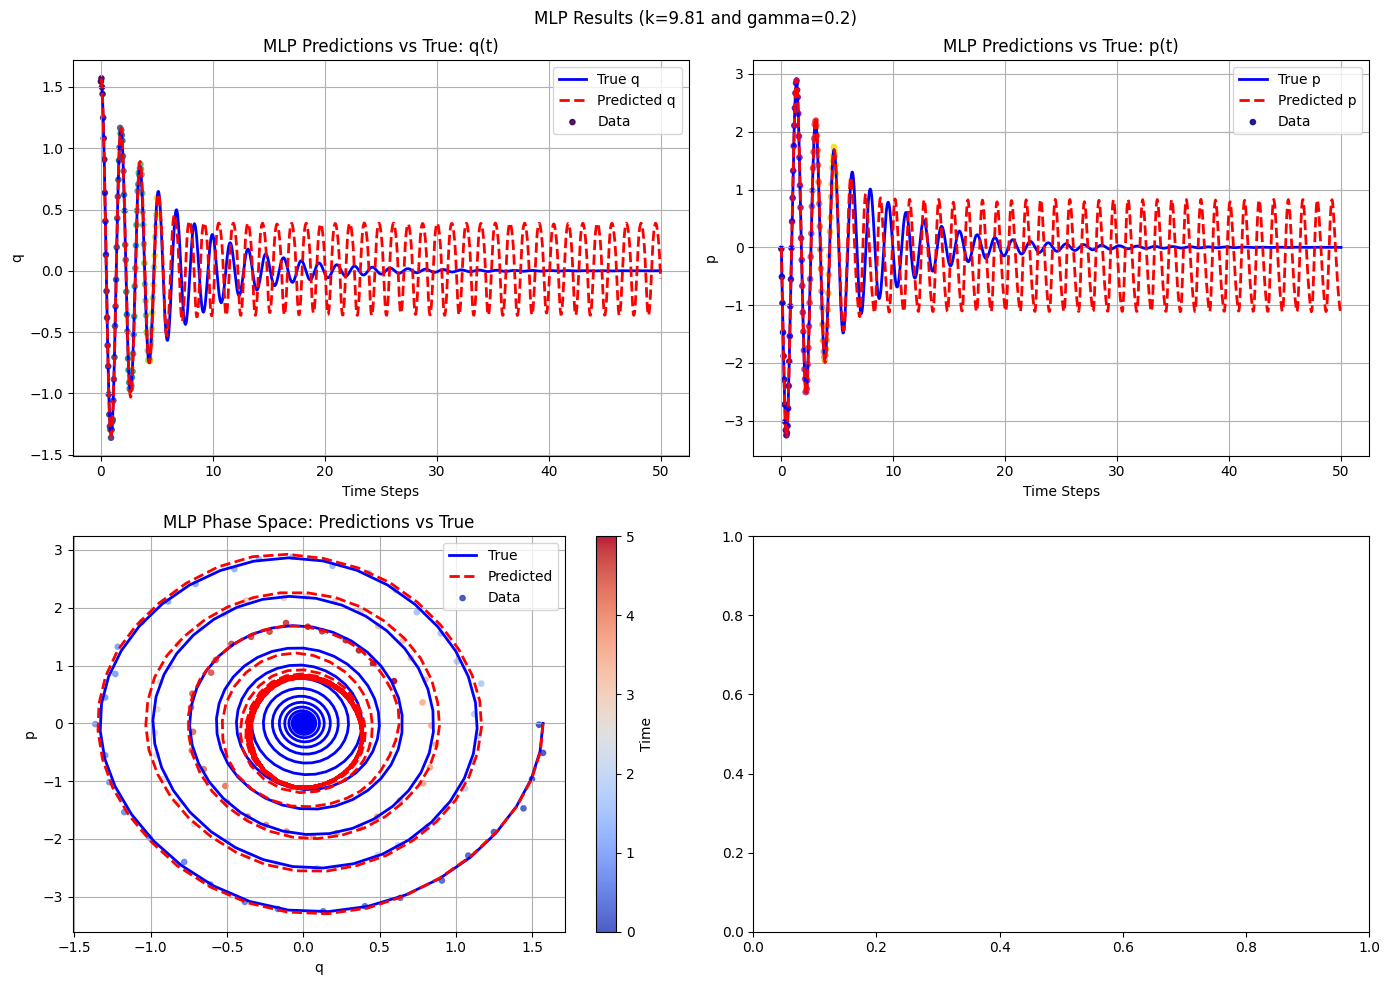

In [115]:
nn_model = MLP(input_dim, 2, hidden_dim)
train_hnn(nn_model, train_loader, epochs=5000)
# Re-run evaluation
evaluate_hnn(nn_model, model_name='MLP')